# Mark and Recapture

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Distributions", "Plots", "DataFrames")

## The Grizzly Bear Problem

In [2]:
using Distributions, Plots, DataFrames
N = 100
K = 23
n = 19

ks = 0:11
ps = pdf.(Hypergeometric(K, N-K, n), ks);

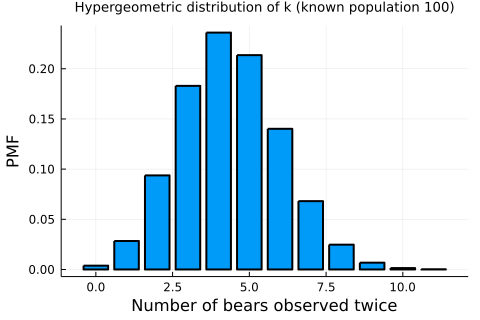

In [3]:
bar(ks, ps, xlabel="Number of bears observed twice",
         ylabel="PMF",
         title="Hypergeometric distribution of k (known population 100)",
         titlefontsize=9)

## The Update

In [4]:
include("empiricaldist.jl"); using .EmpiricalDist
qs = 50:500
prior_N = makeuniform(qs, name="N")
size(prior_N)

(451,)

In [5]:
Ns = prior_N.qs
K = 23
n = 19
k = 4

likelihood = pdf.(Hypergeometric.(K, Ns .- K, n), k);

In [6]:
posterior_N = prior_N .* likelihood
normalize!(posterior_N)

0.07755224277106787

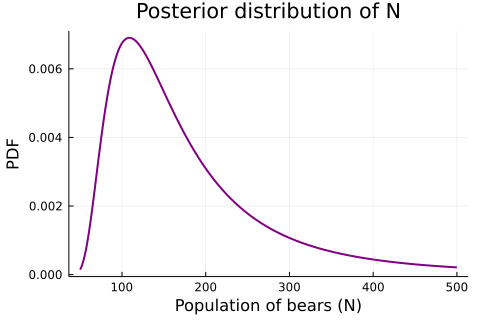

In [7]:
plot(posterior_N, color=:purple,
         xlabel="Population of bears (N)",
         ylabel="PDF",
         title="Posterior distribution of N", legend=false)

In [8]:
maxprob(posterior_N)

109

In [9]:
credibleinterval(posterior_N, 0.9)

2-element Vector{Int64}:
  77
 363

## Two-Parameter Model

In [10]:
K = 23
n = 19
k = 4;

In [11]:
k₁₀ = 23 - 4
k₀₁ = 19 - 4
k₁₁ = 4;

In [12]:
N = 100

observed = k₀₁ + k₁₀ + k₁₁
k₀₀ = N - observed
k₀₀

62

In [13]:
x = [k₀₀, k₀₁, k₁₀, k₁₁]
x

4-element Vector{Int64}:
 62
 15
 19
  4

In [14]:
p = 0.2
q = 1-p
y = [q*q, q*p, p*q, p*p]
y

4-element Vector{Float64}:
 0.6400000000000001
 0.16000000000000003
 0.16000000000000003
 0.04000000000000001

In [15]:
likelihood = pdf(Multinomial(N, y), x)
likelihood

0.0016664011988508176

## The Prior

In [16]:
qs = range(0, 0.99, length=100)
prior_p = makeuniform(qs, name="p");

In [17]:
joint_prior = makejoint(prior_p, prior_N)
size(joint_prior)

(451, 100)

In [18]:
joint_pmf = Pmf(stack(joint_prior))
first(joint_pmf, 3)

┌────────────┬────────────┐
│            │      probs │
├────────────┼────────────┤
│  (50, 0.0) │ 2.21729e-5 │
│ (50, 0.01) │ 2.21729e-5 │
│ (50, 0.02) │ 2.21729e-5 │
└────────────┴────────────┘


In [19]:
typeof(joint_pmf)

Pmf{Float64, Tuple{Int64, Float64}}

In [20]:
typeof(keys(joint_pmf))

Vector{Tuple{Int64, Float64}} (alias for Array{Tuple{Int64, Float64}, 1})

In [21]:
size(joint_pmf)

(45100,)

## The Update

In [22]:
likelihood = copy(joint_pmf);

In [23]:
observed = k₀₁ + k₁₀ + k₁₁

for (N, p) in keys(joint_pmf)
    k₀₀ = N - observed
    x = [k₀₀, k₀₁, k₁₀, k₁₁]
    q = 1-p
    y = [q*q, q*p, p*q, p*p]
    likelihood[(N, p)] = pdf(Multinomial(N, y), x)
end

In [24]:
posterior_pmf = joint_pmf .* likelihood
normalize!(posterior_pmf)

2.967879619027939e-5

In [25]:
joint_posterior = unstack(posterior_pmf);

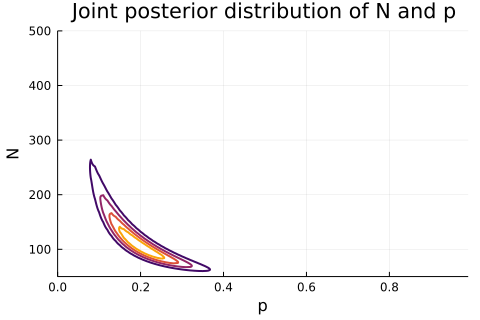

In [26]:
contour(joint_posterior, title="Joint posterior distribution of N and p", xlabel="p", ylabel="N")

In [27]:
posterior2_p = marginal(joint_posterior, 1)
posterior2_N = marginal(joint_posterior, 2);

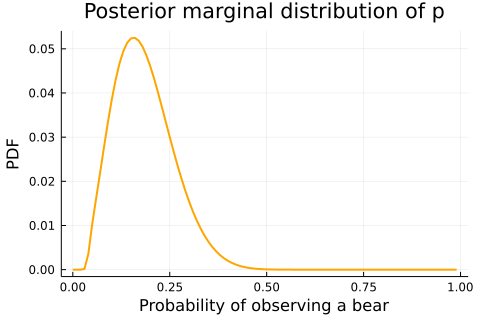

In [28]:
plot(posterior2_p, color=:orange,
         xlabel="Probability of observing a bear",
         ylabel="PDF",
         title="Posterior marginal distribution of p")

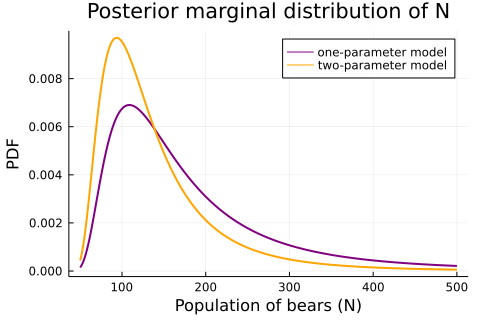

In [29]:
plot(posterior_N, label="one-parameter model", color=:purple)
plot!(posterior2_N, label="two-parameter model", color=:orange)

plot!(xlabel="Population of bears (N)",
         ylabel="PDF",
         title="Posterior marginal distribution of N")

In [30]:
mean(posterior_N), 
      credibleinterval(posterior_N, 0.9)

(173.79880627085828, [77, 363])

In [31]:
mean(posterior2_N), 
      credibleinterval(posterior2_N, 0.9)

(138.75052136472488, [68, 277])

In [32]:
N₁ = 138

138

In [33]:
m = (23 + 19) / 2
p = m/N₁
p

0.15217391304347827

In [34]:
std(Binomial(N₁, p))

4.219519857292647

In [35]:
N₂ = 173
p = m/N₂
p

0.12138728323699421

In [36]:
std(Binomial(N₂, p))

4.2954472470306415

## Joint and Marginal Distributions

In [37]:
using StatsPlots, Plots.PlotMeasures

@userplot JointPlot

"""Show joint and marginal distributions.

joint: DataFrame that represents a joint distribution
options: passed to JointGrid
"""
@recipe function f(h::JointPlot)
    if length(h.args) != 1 || !(typeof(h.args[1]) <: JointDistribution)
        error("Expected a single JoinDistribtion as input")
    end

    j = h.args[1]
    x, y, m = columns(j), rows(j), distribution(j)
    
    marginal_x = vec(sum(m, dims=1))
    marginal_y = vec(sum(m, dims=2))

    legend := false
    link := :both
    framestyle := [:none :axes :none]
    grid := false
    layout := @layout [topmarginal          _
                       contour{0.8w, 0.8h}  rightmarginal]

    # main
    @series begin
        seriestype := :contour
        subplot := 2
        
        x, y, m
    end
    
    ticks := false
    linecolor := :gray
    color := :gray
    # top
    seriestype := :line

    @series begin
        subplot := 1
        x, marginal_x
    end
    
    # right
    # see https://discourse.julialang.org/t/cant-get-marginal-plot-to-work/71685
    seriestype := :shape

    @series begin
        subplot := 3
        [marginal_y; reverse(marginal_y)], [y; reverse(y)]
    end
end

RecipesBase.apply_recipe

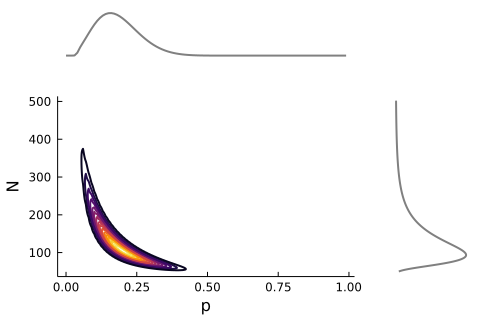

In [38]:
jointplot(joint_posterior, xlabel="p", ylabel="N")

## The Lincoln Index Problem

In [39]:
k₁₀ = 20 - 3
k₀₁ = 15 - 3
k₁₁ = 3;

In [40]:
p₀, p₁ = 0.2, 0.15;

In [41]:
"""Computes the probability for each of 4 categories."""
function compute_probs(p₀, p₁)
    q₀ = 1-p₀
    q₁ = 1-p₁
    return [q₀*q₁, q₀*p₁, p₀*q₁, p₀*p₁]
end

compute_probs

In [42]:
y = compute_probs(p₀, p₁)
y

4-element Vector{Float64}:
 0.68
 0.12
 0.17
 0.03

In [43]:
qs = range(32, 350, step=5) 
prior_N = makeuniform(qs, name="N")
first(prior_N, 3)

┌────┬──────────┐
│    │    probs │
├────┼──────────┤
│ 32 │ 0.015625 │
│ 37 │ 0.015625 │
│ 42 │ 0.015625 │
└────┴──────────┘


In [44]:
data = [0, k₀₁, k₁₀, k₁₁];

In [45]:
likelihood = copy(prior_N)
observed = sum(data)
x = copy(data)

for N in prior_N.qs
    x[1] = N - observed
    likelihood[N] = pdf(Multinomial(N, y), x)
end

In [46]:
posterior_N = prior_N .* likelihood
normalize!(posterior_N)

0.0003425201572557162

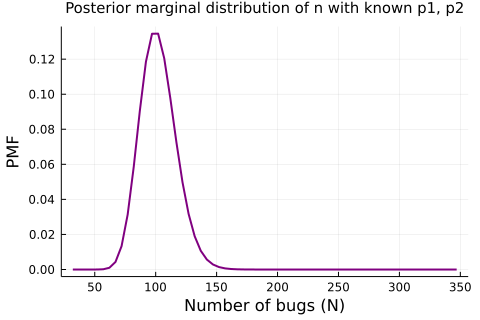

In [47]:
plot(posterior_N, color=:purple,
         xlabel="Number of bugs (N)",
         ylabel="PMF", legend = false,
         title="Posterior marginal distribution of n with known p1, p2",
         titlefontsize=10)

In [48]:
mean(posterior_N), credibleinterval(posterior_N, 0.9)

(102.12500000000001, [77, 127])

## Three-Parameter Model

In [49]:
qs = range(0, 1, length=51)
prior_p₀ = makeuniform(qs, name="p0")
prior_p₁ = makeuniform(qs, name="p1");

In [50]:
joint2 = makejoint(prior_p₀, prior_N)
size(joint2)

(64, 51)

In [51]:
joint2_pmf = Pmf(stack(joint2))
first(joint2_pmf, 3)

┌────────────┬─────────────┐
│            │       probs │
├────────────┼─────────────┤
│  (32, 0.0) │ 0.000306373 │
│ (32, 0.02) │ 0.000306373 │
│ (32, 0.04) │ 0.000306373 │
└────────────┴─────────────┘


In [52]:
joint3 = makejoint(prior_p₁, joint2_pmf)
size(joint3)

(3264, 51)

In [53]:
first(joint3, 3)

┌────────────┬───────────┬───────────┬───────────┬───────────┬───────────┬──────
│            │       0.0 │      0.02 │      0.04 │      0.06 │      0.08 │     ⋯
├────────────┼───────────┼───────────┼───────────┼───────────┼───────────┼──────
│  (32, 0.0) │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0 ⋯
│ (32, 0.02) │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0 ⋯
│ (32, 0.04) │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0073e-6 │ 6.0 ⋯
└────────────┴───────────┴───────────┴───────────┴───────────┴───────────┴──────
                                                              46 columns omitted


In [54]:
joint3_pmf = Pmf(stack(joint3))
first(joint3_pmf, 3)

┌─────────────────┬───────────┐
│                 │     probs │
├─────────────────┼───────────┤
│  (32, 0.0, 0.0) │ 6.0073e-6 │
│ (32, 0.0, 0.02) │ 6.0073e-6 │
│ (32, 0.0, 0.04) │ 6.0073e-6 │
└─────────────────┴───────────┘


In [55]:
size(joint3_pmf)

(166464,)

In [56]:
likelihood = copy(joint3_pmf)
observed = sum(data)
x = copy(data)

for (N, p₀, p₁) in keys(joint3_pmf)
    x[1] = N .- observed
    y = compute_probs(p₀, p₁)
    likelihood[(N, p₀, p₁)] = pdf(Multinomial(N, y), x)
end

In [57]:
posterior_pmf = joint3_pmf .* likelihood
normalize!(posterior_pmf)

8.941088283758006e-6

In [58]:
posterior_N = marginal(posterior_pmf, 1);

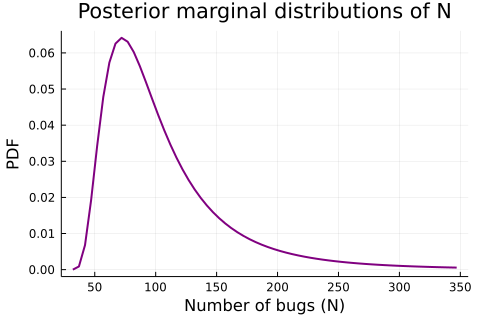

In [59]:
plot(posterior_N, color=:purple,
         xlabel="Number of bugs (N)",
         ylabel="PDF",
         title="Posterior marginal distributions of N")

In [60]:
mean(posterior_N)

105.76561732196447

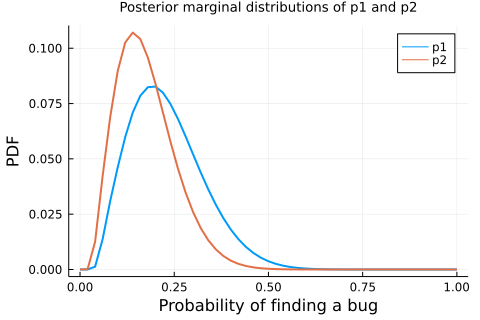

In [61]:
posterior_p₁ = marginal(posterior_pmf, 2)
posterior_p₂ = marginal(posterior_pmf, 3)

plot(posterior_p₁, label="p1")
plot!(posterior_p₂, label="p2")
plot!(xlabel="Probability of finding a bug",
         ylabel="PDF",
         title="Posterior marginal distributions of p1 and p2",
         titlefontsize=9)

In [62]:
mean(posterior_p₁), credibleinterval(posterior_p₁, 0.9)

(0.22970659716777725, [0.1, 0.4])

In [63]:
mean(posterior_p₂), credibleinterval(posterior_p₂, 0.9)

(0.17501172155926065, [0.06, 0.32])

## Summary

## Exercises

In [64]:
# 15.1

data2 = [0, 73, 86, 49];

In [65]:
qs = range(200, 499, step=5)
prior_N = makeuniform(qs, name="N")
first(prior_N, 3)

┌─────┬───────────┐
│     │     probs │
├─────┼───────────┤
│ 200 │ 0.0166667 │
│ 205 │ 0.0166667 │
│ 210 │ 0.0166667 │
└─────┴───────────┘


In [66]:
qs = range(0, 0.98, length=50)
prior_p = makeuniform(qs, name="p")
first(prior_p, 3)

┌──────┬───────┐
│      │ probs │
├──────┼───────┤
│  0.0 │  0.02 │
│ 0.02 │  0.02 │
│ 0.04 │  0.02 │
└──────┴───────┘


In [67]:
# Solution

joint_prior = makejoint(prior_p, prior_N)
first(joint_prior, 3)

┌─────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬───
│     │         0.0 │        0.02 │        0.04 │        0.06 │        0.08 │  ⋯
├─────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼───
│ 200 │ 0.000333333 │ 0.000333333 │ 0.000333333 │ 0.000333333 │ 0.000333333 │  ⋯
│ 205 │ 0.000333333 │ 0.000333333 │ 0.000333333 │ 0.000333333 │ 0.000333333 │  ⋯
│ 210 │ 0.000333333 │ 0.000333333 │ 0.000333333 │ 0.000333333 │ 0.000333333 │  ⋯
└─────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────┴───
                                                              45 columns omitted


In [68]:
# Solution

prior_pmf = Pmf(stack(joint_prior))
first(prior_pmf, 3)

┌─────────────┬─────────────┐
│             │       probs │
├─────────────┼─────────────┤
│  (200, 0.0) │ 0.000333333 │
│ (200, 0.02) │ 0.000333333 │
│ (200, 0.04) │ 0.000333333 │
└─────────────┴─────────────┘


In [69]:
# Solution

observed = sum(data2)
x = copy(data2)
likelihood = copy(prior_pmf)

for (N, p) in keys(prior_pmf)
    x[1] = N - observed
    q = 1-p
    y = [q*q, q*p, p*q, p*p]
    likelihood[(N, p)] = pdf(Multinomial(N, y), x)
end

In [70]:
# Solution

posterior_pmf = prior_pmf .* likelihood
normalize!(posterior_pmf)

1.26622668223882e-6

In [71]:
# Solution

joint_posterior = unstack(posterior_pmf);

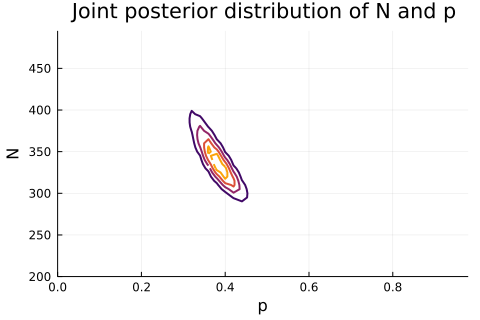

In [72]:
# Solution

contour(joint_posterior, title="Joint posterior distribution of N and p",
        xlabel="p", ylabel="N")

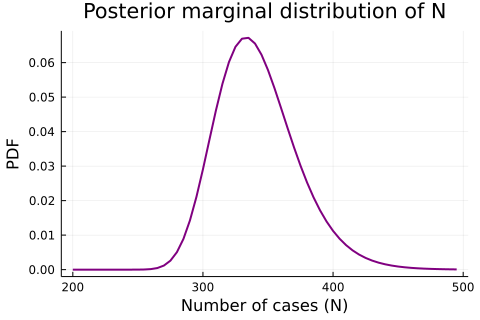

In [73]:
# Solution

marginal_N = marginal(joint_posterior, 2)
plot(marginal_N, color=:purple,
         xlabel="Number of cases (N)",
         ylabel="PDF",
         title="Posterior marginal distribution of N")

In [74]:
# Solution

mean(marginal_N), credibleinterval(marginal_N, 0.9)

(342.1317040018941, [295, 400])

In [75]:
# 15.2

data3 = [0, 63, 55, 18, 69, 17, 21, 28];

In [76]:
q = 1-p
ps = [q*q, q*p, p*q, p*p];

In [77]:
# we're not going through a DataFrame
cartesian_product(args...) = reshape(collect(Iterators.product(args...)), :, 1)

cartesian_product (generic function with 1 method)

In [78]:
p = 0.2
t = (1-p, p)
df = cartesian_product(t, t, t)

8×1 Matrix{Tuple{Float64, Float64, Float64}}:
 (0.8, 0.8, 0.8)
 (0.2, 0.8, 0.8)
 (0.8, 0.2, 0.8)
 (0.2, 0.2, 0.8)
 (0.8, 0.8, 0.2)
 (0.2, 0.8, 0.2)
 (0.8, 0.2, 0.2)
 (0.2, 0.2, 0.2)

In [79]:
y = vec([prod(x) for x in df])

8-element Vector{Float64}:
 0.5120000000000001
 0.12800000000000003
 0.12800000000000003
 0.03200000000000001
 0.12800000000000003
 0.03200000000000001
 0.03200000000000001
 0.008000000000000002

In [80]:
# Solution

observed = sum(data3)
x = copy(data3)
likelihood = copy(prior_pmf)

for (N, p) in keys(prior_pmf)
    x[1] = N - observed
    t = (1-p, p)
    df = cartesian_product(t, t, t)
    y = vec([prod(x) for x in df])
    likelihood[(N, p)] = pdf(Multinomial(N, y), x)
end

In [81]:
# Solution

posterior_pmf = prior_pmf .* likelihood
normalize!(posterior_pmf)

2.635951782955762e-16

In [82]:
# Solution

joint_posterior = unstack(posterior_pmf);

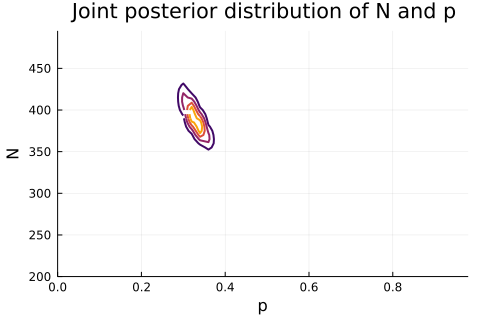

In [83]:
contour(joint_posterior, xlabel="p", ylabel="N",
        title="Joint posterior distribution of N and p")

In [84]:
# Solution

marginal3_N = marginal(joint_posterior, 2);

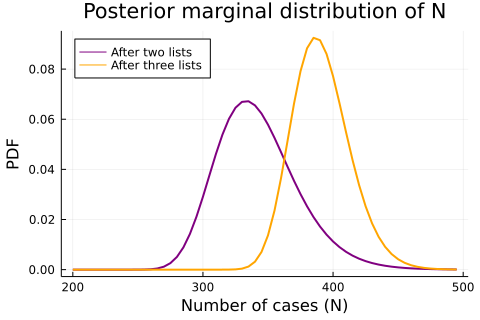

In [85]:
# Solution

plot(marginal_N, label="After two lists", color=:purple)
plot!(marginal3_N, label="After three lists", color=:orange, legend=:topleft)
xlabel!("Number of cases (N)")
ylabel!("PDF")
title!("Posterior marginal distribution of N")

In [86]:
# Solution

mean(marginal_N), credibleinterval(marginal_N, 0.9)

(342.1317040018941, [295, 400])

In [87]:
# Solution

mean(marginal3_N), credibleinterval(marginal3_N, 0.9)

(391.00501407503623, [360, 430])